In [1]:
import os
REPO_ROOT=os.path.dirname(os.path.abspath('.'))
os.chdir(REPO_ROOT)

# prepare essential environment

In [2]:
!pip install seaborn

# prepare VATEX fine-tuned models, test loader, etc

In [3]:
import torch
from config import Constants
from models import load_model

path_base = f'{Constants.base_checkpoint_path}/VATEX/Transformer/Base/median_ViT_ami/best.ckpt'
path_cabase = f'{Constants.base_checkpoint_path}/VATEX/Transformer/CABase/median_ViT_VA/best.ckpt'
path_care = f'{Constants.base_checkpoint_path}/VATEX/Transformer/CARE/median_ViT_VA_VAT/best.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

models = []
models_names = ['Baseline', 'CA-Baseline', 'CARE']
for path in [path_base, path_cabase, path_care]:
    print(path)
    model = load_model(
        path,
        device=device,
        strict=True,
        base_data_path=Constants.base_data_path
    )
    models.append(model)

init COCO-EVAL scorer
./exps/VATEX/Transformer/Base/median_ViT_ami/best.ckpt
./exps/VATEX/Transformer/CABase/median_ViT_VA/best.ckpt
./exps/VATEX/Transformer/CARE/median_ViT_VA_VAT/best.ckpt


In [4]:
from dataloader import get_loader
loader = get_loader(models[-1].get_opt(), mode='test', is_validation=True, not_shuffle=True)

In [5]:
import pickle
from dataloader import get_ids_set

split = pickle.load(open(f'{Constants.base_data_path}/VATEX/info_corpus.pkl', 'rb'))['info']['split']
refs = pickle.load(open(f'{Constants.base_data_path}/VATEX/refs.pkl', 'rb'))

train_ids = get_ids_set('train', split, is_vatex_activate=True)
all_training_captions = [] # used to obtain video-to-text retrieval results
for _id in train_ids:
    vid = 'video%d'%_id
    this_captions = [item['caption'] for item in refs[vid]]
    all_training_captions.extend(this_captions)

# define prediction & visualization functions

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import glob
import h5py
import numpy as np

from matplotlib.pyplot import MultipleLocator
from pretreatment.extract_frames_from_videos import extract_frames
from dataloader import get_frame_ids
from misc.utils import get_uniform_items_from_k_snippets
from PIL import Image
    

@torch.no_grad()
def get_pred_caption(model, device, loader, vid):
    batch = loader.dataset.get_specific_data_by_vid_and_cap_id(vid, 0, device=device)
    outputs = model.translate_step(batch=batch, vocab=model.get_vocab(), assert_only_a_caption_per_video=True)
    pred_caption = outputs[vid][0]['caption']
    return pred_caption


@torch.no_grad()
def get_forward_results(model, device, loader, vid, text=None):
    model.eval()
    model.to(device)

    batch = loader.dataset.get_specific_data_by_vid_and_cap_id(vid, 0, text=text, device=device)
    results = model.captioner(batch)

    opt = model.get_opt()
    if 'concat' in opt.get('use_attr_type', ''):
        attr_attention_probs = results['all_inter_attentions'][0][:, :, :, -opt['use_attr_topk']:]
        assert attr_attention_probs.size(-1) == opt['use_attr_topk'], attr_attention_probs.shape
    else:
        attr_attention_probs = results['attr_attention_probs'][0]

    eos_index = batch['labels'][0, :].cpu().numpy().tolist().index(Constants.EOS)
    probs = attr_attention_probs[0, :, :eos_index+1, :] # (num_heads, seq_len, use_attr_topk)
    return probs, results


def get_predictions(model, device, loader, vid):
    caption = get_pred_caption(model, device, loader, vid)

    opt = model.get_opt()
    if opt.get('attribute_prediction', False) and opt.get('use_attr', False):
        attention_towards_concepts, results = get_forward_results(model, device, loader, vid, text=caption)
    
        vocab = model.get_vocab()
        topk_indices = results['semantic_labels'][0].cpu().numpy()
        topk_concepts = [vocab[i + Constants.attribute_start] for i in topk_indices]
    
        return {
            'caption': caption,
            'topk_concepts': topk_concepts,
            'heatmap_weights': attention_towards_concepts.mean((0, 1)), # averaged over heads and tokens
        }
    
    return {'caption': caption}


def show_video(
    vid, 
    all_videos_path = f'{Constants.base_data_path}/VATEX/all_videos', 
    tmp_path='./dummy', 
    n_frames=28, 
    n_col=7,
    figsize=(15, 6),
    save_path=None,
):
    video_path = os.path.join(all_videos_path, vid + '.mp4')
    extract_frames(video_path, tmp_path, 'png', strategy=0)
    
    frames = sorted(glob.glob(os.path.join(tmp_path, '*.{}'.format('png'))))
    frames = get_uniform_items_from_k_snippets(frames, Constants.n_total_frames)
    frame_ids = get_frame_ids(len(frames), n_frames, 'equally_sampling')

    images = []
    for index in frame_ids:
        image = Image.open(frames[index]).convert('RGB')
        images.append(image)

    fig = plt.figure(figsize=figsize)

    n_row = n_frames // n_col
    if n_row * n_col < n_frames:
        n_row += 1
    
    for i in range(len(images)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.imshow(images[i])
        ax.set_yticks([])
        ax.set_xticks([])

    plt.subplots_adjust(wspace=0, hspace=0.05)

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        for i, image in enumerate(images):
            image.save(os.path.join(save_path, f'{i}.png'))


def show_concept_heatmap(
    predictions,
    n_columns=10,
    figsize=(8,0.6),
    save_path=None,
    x_shift=0.12, y_shift=0.7,
    adjust_kwargs={'left': 0.005, 'right': 0.948, 'top': 1.0, 'bottom': 0.0},
    font_size=13,
    splits=[49, 1],
    cbar_kws={'ticklocation': 'auto'},
):
    if 'heatmap_weights' not in predictions:
        return
    
    plt.rcParams.update({
        'font.size': font_size, 
        'font.family': 'Times New Roman'
    })
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, sum(splits))
    ax = fig.add_subplot(gs[:splits[0]])
    cbar_ax = fig.add_subplot(gs[splits[0]:])

    weights = predictions['heatmap_weights']
    n_concepts = len(weights)
    n_rows = n_concepts // n_columns
    assert n_rows * n_columns == n_concepts
    
    sns.heatmap(weights.view(n_rows, n_columns).cpu().numpy(), 
                ax=ax, mask=None, linewidths=0, cmap='Blues', 
                cbar_ax=cbar_ax, cbar_kws=cbar_kws)
    
    dis = (weights.max() - weights.min()).item()
    if dis < 0.04:
        v = 0.015
    else:
        v = int(dis/2.0 * 100)/100
    cbar_ax.yaxis.set_major_locator(MultipleLocator(v))
    
    for i in range(n_concepts):
        concept = predictions['topk_concepts'][i]
        if len(concept) > 10:
            fontsize = font_size - 4
        elif len(concept) == 10:
            fontsize = font_size - 2.5
        else:
            fontsize = font_size

        if weights[i] > 0.7 * weights.max():
            color = 'white'
        else:
            color = 'black'
        ax.text(i % n_columns + x_shift, i // n_columns + y_shift, concept, 
                fontsize=fontsize, color=color)

    ax.axis('off')
    plt.subplots_adjust(**adjust_kwargs)
    if save_path is not None:
        fig.savefig(save_path, dpi=300)


def log(msg, recorder=None):
    print(msg)
    if recorder is not None:
        assert type(recorder) is list
        recorder.append(msg)


def run(
    models, 
    models_names,
    device, 
    loader, 
    vid, 
    all_training_captions=[],
    save=False, 
    save_folder='./results/VATEX_qualitative_examples'
):
    assert len(models) == len(models_names)
    
    if save:
        base_save_path = os.path.join(save_folder, vid)
        os.makedirs(base_save_path, exist_ok=True)
    
    show_video(vid, save_path=os.path.join(base_save_path, 'frames') if save else None)

    recorder = []
    
    log(f"vid: {vid}", recorder)
    log(f"YouTubeID: {loader.dataset.vid2id[vid]}", recorder)
    
    log("Ground Truth:", recorder)
    all_ground_truth_captions = loader.dataset.get_preprocessed_gt_sentences_by_vid(vid, add_special_tokens=False)
    for i, caption in enumerate(all_ground_truth_captions):
        log(f"{i}: {caption}", recorder)

    log("\nModel Predictions:", recorder)
    feats_r, retrieval_topk, retrieval_db = None, None, None
    
    for model, name in zip(models, models_names):
        predictions = get_predictions(model, device, loader, vid)
        log(f"{name}: {predictions['caption']}", recorder)
        
        show_concept_heatmap(
            predictions,
            save_path=os.path.join(base_save_path, f'{name}_concept_heatmap.png') if save else None
        )

        opt = model.get_opt()
        if opt.get('predictor_modality_flags', None) is not None and 'T' in opt['predictor_modality_flags']:
            feats_r = opt['feats_r']
            retrieval_topk = opt['retrieval_topk']
            retrieval_db = h5py.File(feats_r, 'r')

    if retrieval_db is not None:
        assert len(all_training_captions)
        log("\nVideo-to-Text Retrieval:", recorder)
        inds = np.asarray(retrieval_db[vid+'_i'])[:retrieval_topk]
        for i, ind in enumerate(inds):
            log(f"{i}: {all_training_captions[ind]}", recorder)
        
    if save:
        with open(os.path.join(base_save_path, 'log.txt'), 'w') as f:
            f.write('\n'.join(recorder))

# Start inference

 cleanup: ./dummy/
vid: video30993
YouTubeID: 2VGhlqVs7T8_000163_000173
Ground Truth:
0: a mother and three children counting the easter eggs they collected
1: a three children and one <unk> in plaing in a ground and a lady in take in toys and one child is running
2: a woman is kneeling down picking up easter eggs with her three kids around her
3: three kids are easter egg hunting with mom and dad asks if they found them all
4: an adult helps three kids wearing winter hats to find easter eggs
5: a woman was with three kids while helping them to pick up their eggs
6: a woman is looking at a pile of plastic eggs as three children stand around her
7: some kids found colored eggs in the yard and are watching a woman count them
8: children counting their eggs at the end of an easter egg hunt while an adult talks to them
9: outside in a grassy yard a woman and 3 small children stand around several colored eggs on the ground

Model Predictions:
Baseline: a group of kids are outside playing wi

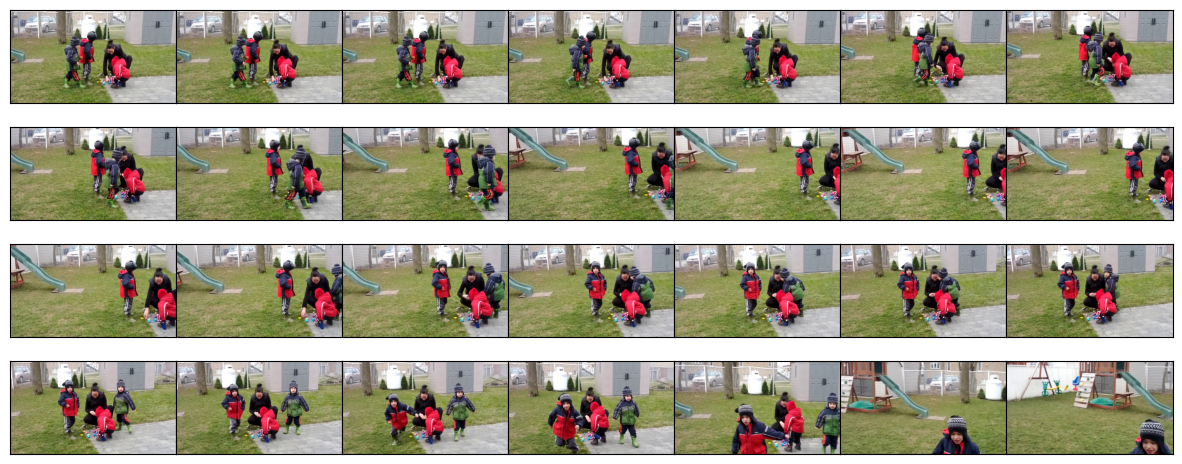

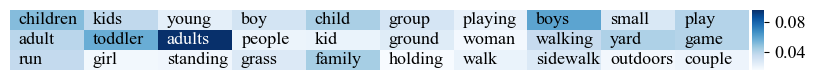

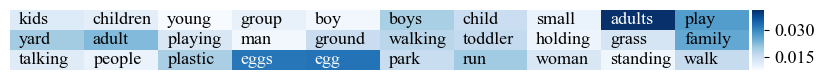

In [7]:
run(models, models_names, device, loader, 'video30993', all_training_captions=all_training_captions, save=True)

 cleanup: ./dummy/
vid: video29620
YouTubeID: O-Hy9k_Kf3c_000019_000029
Ground Truth:
0: a man is showing how to shape an animal out of balloons
1: a man demonstrates the beginning of a balloon animal while explaining what he does
2: a man is demonstrating how to form a balloon into different shapes
3: a guy is demonstrating how to do a balloon animal
4: a person presses a air filled balloon on one end and he shows the bend portion of the balloon
5: a man is explaining how to make a shape while squeezing a blue balloon
6: a man tells another how to make a bend in a balloon demonstrating making balloon animal shapes
7: a man in a suit and tie is demonstrating and explaining how to make balloon animals
8: a man narrates as he begins to bend a balloon into the shape of an elephant and an off-screen male voice makes a sound of <unk>
9: the man is demonstrating how to create a bend when creating an animal shape from a balloon

Model Predictions:
Baseline: a man is showing how to properly ti

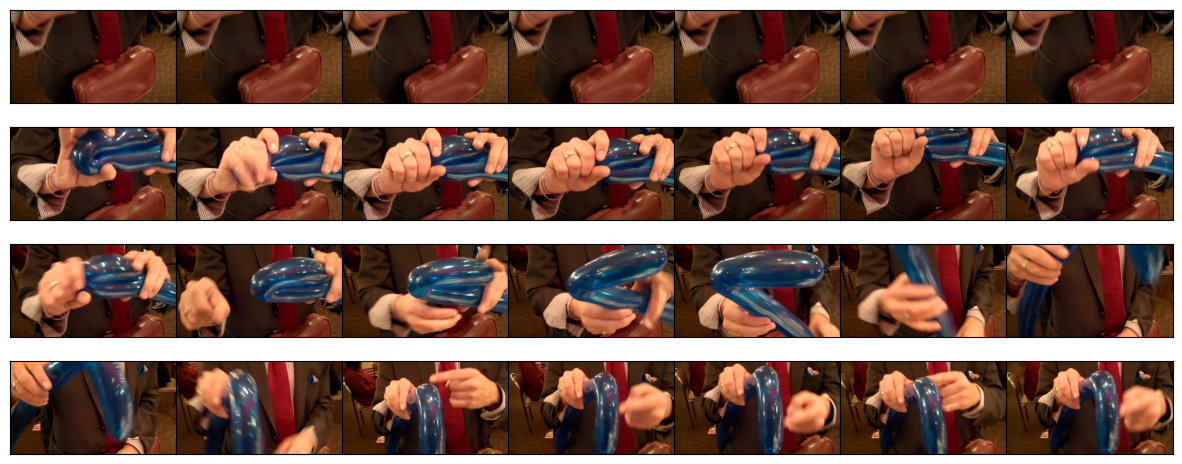

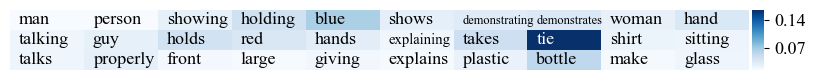

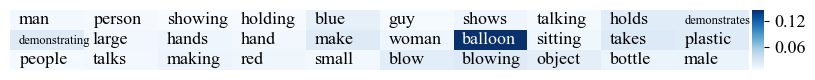

In [8]:
run(models, models_names, device, loader, 'video29620', all_training_captions=all_training_captions, save=True)

 cleanup: ./dummy/
vid: video29291
YouTubeID: kmFC4sOQZ4c_000007_000017
Ground Truth:
0: a community event in which people gather together to help clean up a natural area
1: people pick up litter outdoors placing the litter into plastic bags
2: outside on a field a group of people have garbage bags and are picking up garbage
3: a commercial for outdoor activities showing vidoes of people hiking boating and picking up litter
4: sanitation workers are hard at work picking <unk> in the bushes and on water
5: this group of young people and adult leaders are picking up trash at the riverbank as part of the spring litter <unk> of this natural area
6: the kids are walking around near the ocean and picking up the garage that people have left
7: a group of people are in the forest attempting to clean the litter
8: a group of people are out cleaning up the trash from water and land
9: a group of people picking up litter in a forest and body of water

Model Predictions:
Baseline: a man and a woma

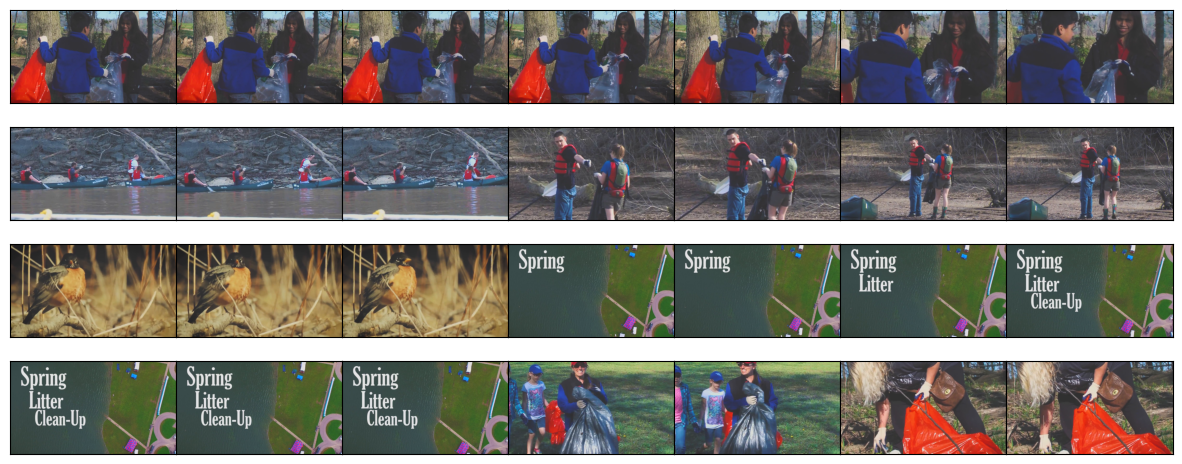

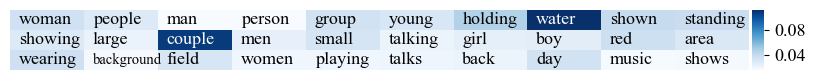

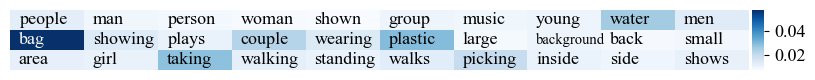

In [9]:
run(models, models_names, device, loader, 'video29291', all_training_captions=all_training_captions, save=True)

 cleanup: ./dummy/
vid: video31479
YouTubeID: eK_gVBy2kC8_000000_000010
Ground Truth:
0: commercial of a person using a three dollar corded mini drill
1: a man has a piece of wood in a vice grip and preparing to drill a hole in the wood as a diy project
2: white words are being displayed across a black screen fading into a picture of a drill with a price stating as is followed by a demonstration of the drill
3: a person starts to drill a hole in a piece of wood clamped in a vise
4: someone shows the labels where they have bought a used drill and then show the drill in action
5: a person with a drill takes a piece of wood and drills into it
6: a photo of an electric device is shown then video is seen of a man drilling into some wood in a vice with a cordless drill
7: the title a three dollar diy drill then shows someone drilling into a small piece of wood
8: a man holds a corded drill and drills into a piece of wood
9: a man is drilling into a small piece of wood

Model Predictions:
Bas

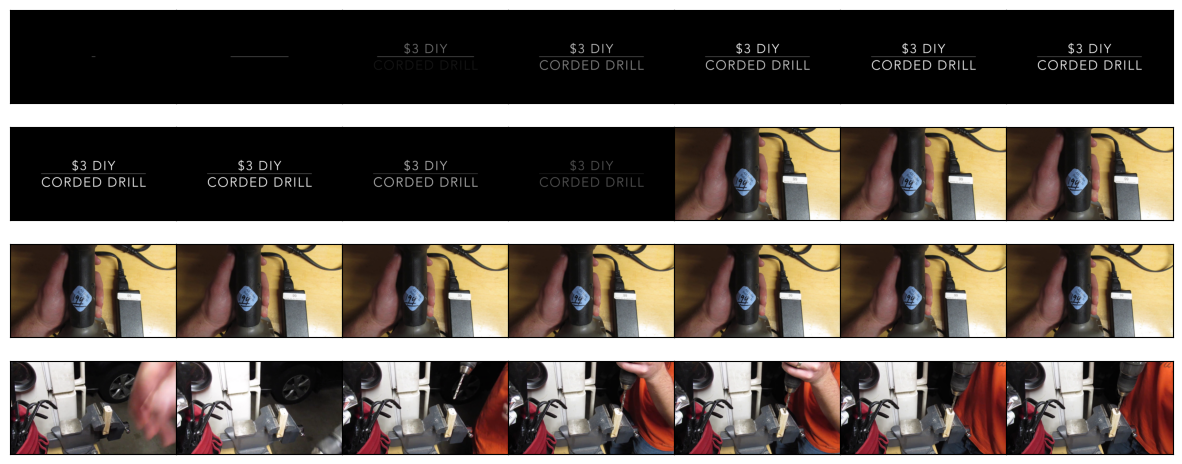

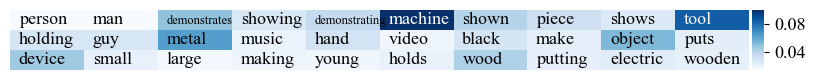

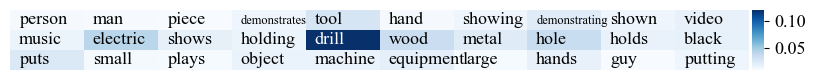

In [10]:
run(models, models_names, device, loader, 'video31479', all_training_captions=all_training_captions, save=True)

 cleanup: ./dummy/
vid: video34114
YouTubeID: bmFx-e0jdl0_000059_000069
Ground Truth:
0: a person doing graffiti on big storage containers using spray cans
1: someone is spray painting graffiti on a wall with different colors
2: men are drawing graffiti on a train then walking away on the tracks
3: a person in a black hat is painting graffiti on a railroad car
4: a man wearing a bandana is using spray paint to decorate a trailer and two men are walking on train railings
5: a young man is applying paint to a van as two people walk on train <unk>
6: a man spray paints graffiti on a wall and then two men are seen walking on train tracks
7: a man is spray painting a train and then him and someone else walk off
8: a man painting on the side of a train and two people are walking on train tracks
9: a man spray paints an image on the side of a train car

Model Predictions:
Baseline: a group of people are walking around in a field
CA-Baseline: a group of people are playing a game of rock paper 

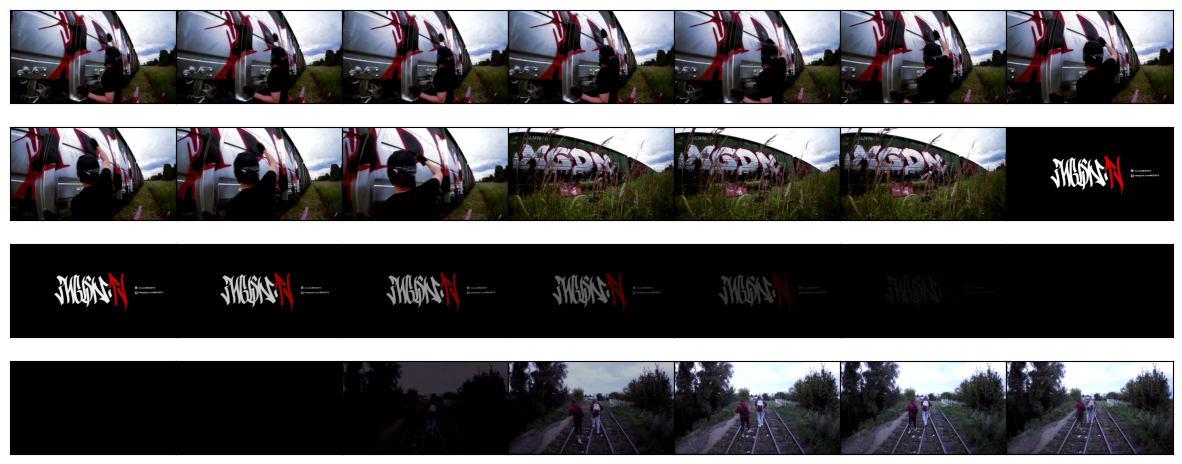

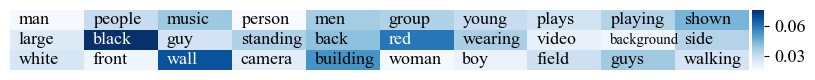

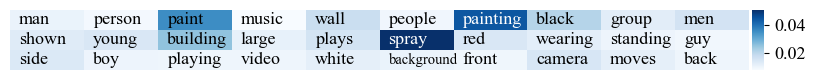

In [11]:
run(models, models_names, device, loader, 'video34114', all_training_captions=all_training_captions, save=True)

 cleanup: ./dummy/
vid: video33569
YouTubeID: VL8Xk0NznFY_000003_000013
Ground Truth:
0: two people sit on a carpet while playing with two black and white puppies
1: two people are sitting on the floor playing with two puppies
2: two dogs are playing while their owners are sitting down and interacting with them
3: two young boys are playing with a couple of puppies on the carpet
4: people are sitting on the floor playing with two puppies
5: two people sitting on a rug are playing with two puppies
6: people sit on the ground playing with two small black and white dogs
7: two youngsters are kneeling on the floor and playing with two black and white puppies
8: two people are on the floor playing with two puppies
9: two young puppies are running around and try to poop

Model Predictions:
Baseline: a woman is petting a dog on the floor while a dog watches
CA-Baseline: a woman is petting a dog while the dog is barking in the background
CARE: a woman is petting a dog and the dog is sitting on

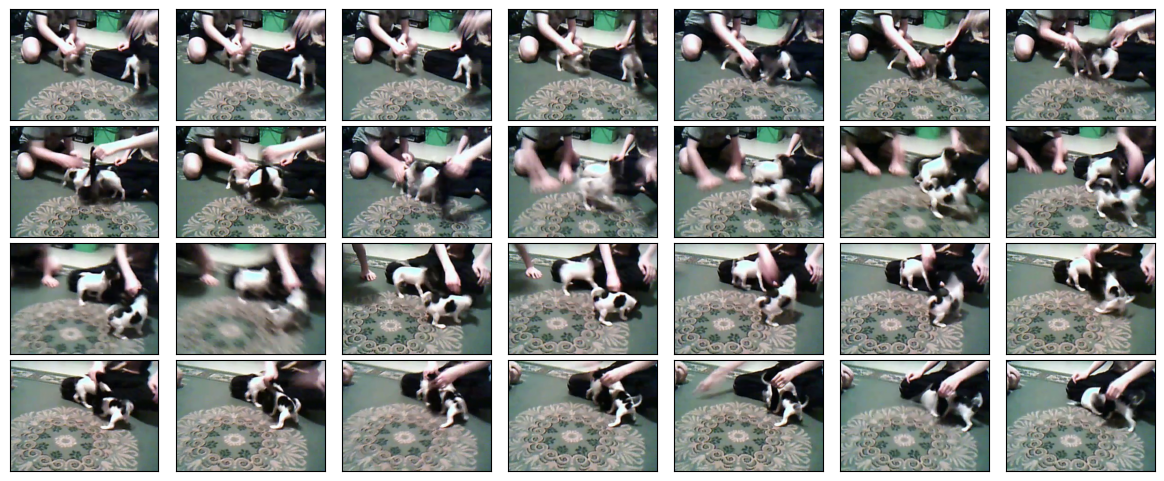

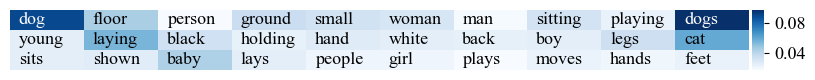

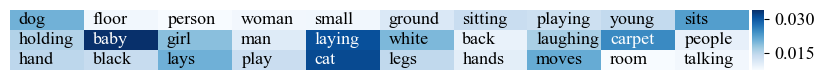

In [12]:
run(models, models_names, device, loader, 'video33569', all_training_captions=all_training_captions, save=True)